A data matrix $Y$ is made up of two submatrices, $Y_1$ and $Y_2$ of size $I \times J_n$. The task is to
solve a distributed low-rank approximation by two agents, such that each agent has only one part
of the data $Y$, and does not have access to the other parts of the data.

Derive the algorithms to update $\{U_n, V_n\}$ by the $n$-th agent for the following problem
$$
\begin{align*}
\min \quad & \frac{1}{2} ||Y_1 - U_1V_1^T||_F^2 + \frac{1}{2}||Y_2 - U_2V_2^T||_F^2\\
s.t \quad & U_1 = U_2
\end{align*}
$$


$$
\begin{align*}
\mathcal{L} &= \frac{1}{2} ||Y_1 - U_1V_1^T||_F^2 + \frac{1}{2}||Y_2 - U_2V_2^T||_F^2 + \frac{\alpha}{2}||U_1 - U_2 -T||^2_F\\

\frac{\partial \mathcal{L}}{\partial V_1} &= U_1^T(Y_1 - U_1V_1^T)=0 \quad => \quad V_1^* = ((U_1^TU_1)^{-1}U_1^TY_1)^T\\

||Y_1 - U_1V_1^{*T}||_F^2 & = ||Y_1 - U_1(U_1^TU_1)^{-1}U_1^TY_1|| =[\text{SVD decomposition } U_1 = A\Sigma B^T]= \\
& = ||Y_1-AA^TY_1||_F^2 = ||Y_1||_F^2 +||AA^TY_1||_F^2 - 2tr(Y_1^TAA^TY_1)=\\
&=||Y_1||_F^2 +||A^TY_1||_F^2 - 2||A^TY_1||^2_F = ||Y_1||_F^2 -||A^TY_1||_F^2\\

||U_1 - U_2 -T||^2_F & = ||U_1 - D||^2_F =||A\Sigma B^T - D||^2_F\\

\mathcal{L} & = \frac{1}{2}||Y_1||_F^2 -\frac{1}{2}||A^TY_1||_F^2 + \frac{1}{2}||Y_2 - U_2V_2^T||_F^2 + \frac{\alpha}{2}||A\Sigma B^T - D||^2_F\\
\frac{\partial \mathcal{L}}{\partial \Sigma} &=0 => \Sigma^* = A^TDB\\

\mathcal{L} & = \frac{1}{2}||Y_1||_F^2 -\frac{1}{2}||A^TY_1||_F^2 + \frac{1}{2}||Y_2 - U_2V_2^T||_F^2 + \frac{\alpha}{2}||AA^TD - D||^2_F\\
\min_A \mathcal{L} & = \min_A -\frac{1}{2}||A^TY_1||_F^2 + \frac{\alpha}{2}||AA^TD - D||^2_F =\\
&=\min_A -\frac{1}{2}||A^TY_1||_F^2 + \frac{\alpha}{2}(||A^TD||^2_F + ||D||^2_F - 2||A^TD||_F^2)\\
&=\min_A -\frac{1}{2}||A^TY_1||_F^2 - \frac{\alpha}{2}||A^TD||^2_F\\
&=\max_A tr(Y_1^TAA^TY_1 - \alpha D^TAA^TD)\\
&=\max_A tr(A^T(Y_1Y_1^T - \alpha DD^T)A)\\
\end{align*}
$$
A =  R -leading eigenvectors of matrix $Y_1Y_1^T - \alpha DD^T$\
For $V_2^*$ formula is similar to $V_1^*$ because of simmetry.\
$$||U_1 - U_2 -T||^2_F = ||U_2 - U_1 +T||^2_F$$
$D_2 = U_1 - T$ and $A_2$ for $U_2$ should be similare to $A$ for $U_1$ because of simmetry.

Final updates:

1)
$$
\begin{align*}
    D &= U_2 + T\\
    A &=  R - \text{ leading eigenvectors of matrix } Y_1Y_1^T - \alpha DD^T\\
    \Sigma^*B^T &= A^TD => U_1^* = AA^TD\\
    V_1^* &= ((U_1^TU_1)^{-1}U_1^TY_1)^T
\end{align*}
$$
2)
$$
\begin{align*}
    D &= U_1 - T\\
    A &=  R - \text{ leading eigenvectors of matrix } Y_2Y_2^T - \alpha DD^T\\
    U_2^* &= AA^TD\\
    V_2^* &= ((U_2^TU_2)^{-1}U_2^TY_2)^T
\end{align*}
$$
3)
$$T =T_{prev}+U^*_2-U^*_1$$



In [1]:
import numpy as np
from numpy.linalg import svd, eig, inv
import matplotlib.pyplot as plt
from PIL import Image
import cv2

img = cv2.imread("airplane.jpg")
shape = (600, 600)
img = cv2.resize(img, (600, 600))
Y = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(float)

In [2]:
J = Y.shape[1] // 2
Y1 = Y[:, :J]
Y2 = Y[:, J:]

In [3]:
def get_U_V(Y, T, alpha, U1=None, U2=None):
    if U1 is None:
        D = U2 + T
    elif U2 is None:
        D = U1 - T
    R = D.shape[1]
    mat = Y @ Y.T - alpha * D @ D.T
    _, eigenvectors = eig(mat)
    A = eigenvectors[:, :R]
    U = A @ A.T @ D
    V = (inv(U.T @ U) @ U.T @ Y).T
    return U, V


def update_T(T_prev, U2, U1):
    return T_prev + U2 - U1


def get_score(Y, U, V):
    return np.linalg.norm(Y - U @ V.T, "fro") ** 2


def plot(rank, result_img, primal_img):
    fig, ax = plt.subplots(ncols=2)
    fig.suptitle(f" rank = {rank}")
    ax[0].set_title("result img")
    ax[1].set_title("primal img")
    ax[0].imshow(np.real(result_img), cmap="gray")
    ax[1].imshow(np.real(primal_img), cmap="gray")
    fig.show()

Give an example of two agents fitting an image Y.\
Report the approximation error $err1$ and the difference $||U_1 − U_2||_F^2$ between $U1$ and $U2$.\
Check the approximation error after exchanging $U_1$ and $U_2$ -  $err2$.

rank = 2, error1 = 229622028.5063237, error2 = 508835645.1671115, U1-U2 distance = 4.864087271041002
rank = 10, error1 = 69800916.99687403, error2 = 3268974718.5229964, U1-U2 distance = 13.087975037182579
rank = 24, error1 = 29840213.682771675, error2 = 5032585725.268271, U1-U2 distance = 21.095415568257792


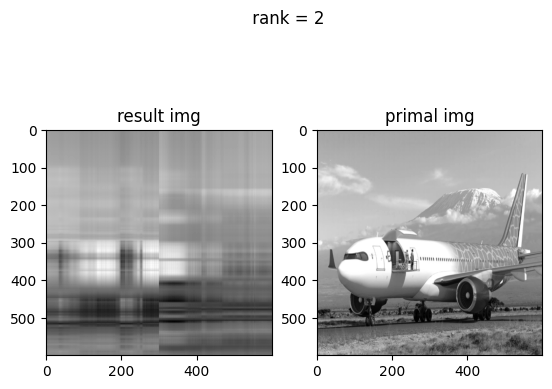

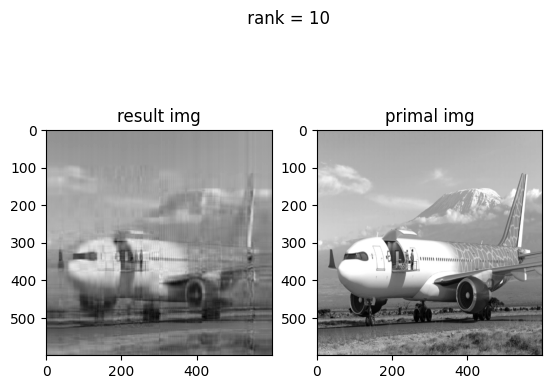

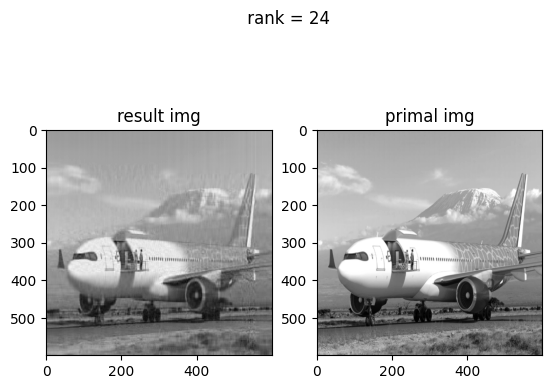

In [4]:
for R in [2, 10, 24]:
    V1 = np.random.random((J, R))
    U1 = np.random.random((Y.shape[0], R))

    V2 = np.random.random((J, R))
    U2 = np.random.random((Y.shape[0], R))

    T = np.random.random(U1.shape)
    alpha = 10
    for _ in range(3):
        U1, V1 = get_U_V(U2=U2, Y=Y1, T=T, alpha=alpha)
        U2, V2 = get_U_V(U1=U1, Y=Y2, T=T, alpha=alpha)
        T = update_T(T, U2=U2, U1=U1)
        # print(get_score(Y1, U1, V1))

    result_img = np.concatenate([U1 @ V1.T, U2 @ V2.T], axis=1)
    error1 = get_score(Y1, U1, V1) + get_score(Y2, U2, V2)
    error2 = get_score(Y1, U2, V1) + get_score(Y2, U1, V2)
    U_dist = np.linalg.norm(U1 - U2, "fro") ** 2
    print(
        f"rank = {R}, error1 = {error1}, error2 = {error2}, U1-U2 distance = {U_dist}"
    )
    plot(R, result_img, Y)

Are the two approximation errors are significantly different?\
If so, explain why the algorithm fails and reformulate the problem if possible.


error1 and error2 are significantly different because $U_1$ and $U_2$ are different matrices with small scale factor.
As far as we approximate $Y_1$ with $U_1V_1^T$ s.t. $U_1 =U_2$ the scale factor of $U_1V_1^T$ is containce in $V_1$ and $U_1$ ramaince ralativly small in terms of norm.
So then we compare $U_1$ and $U_2$ the distance error is small because of small scale factor of $U_1$ and by the same logic $U_2$.

So if we force $U$ be orthogonal we could resolve that issue.

$$
\begin{align*}
\min \quad & \frac{1}{2} ||Y_1 - U_1V_1^T||_F^2 + \frac{1}{2}||Y_2 - U_2V_2^T||_F^2\\
s.t \quad & U_1^TU_1 = I\\
&U_2^TU_2 = I\\
&U_1^TU_2 = I\\

\end{align*}
$$